# Spotify Review dataset
- Use NLTK to explore the data and:
- Find Spotify user pain points
- Find what people love about Spotify

## Import and install dependencies

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords

## Prepare the data

In [4]:
data = pd.read_csv('C:/Users/user/Documents/coding/spotify reviews/reviews.csv')

# Set time of review as dataframe index (row name)
data.Time_submitted = pd.to_datetime(data.Time_submitted)
data.set_index('Time_submitted',inplace=True)

### Not much preparation needed. I just want to plot a graph showing:
- Mean daily rating,
- A rolling window average of daily ratings, and 
- Count of reviews

In [5]:
# Aggregate ratings by day in a new dataframe. Create new columns: number of ratings per day, and 7-day rolling window average.
df1 = pd.DataFrame(data.Rating).resample('D').mean()
df1['Count'] = data.Rating.resample('D').count()
df1['Rolling window average'] = df1.Rating.rolling(window='7D').mean()

## Exploratory Data Analysis with NLTK

Text(0, 0.5, 'Number of reviews')

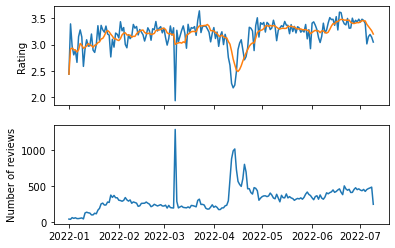

In [6]:
x = df1.index
y1 = df1.Count
y2 = df1.Rating
y3 = df1['Rolling window average']

fig = plt.figure()
ax1, ax2 = fig.subplots(2,1,sharex=True)
ax1.plot(x,y2,'C0',x,y3,'C1')
ax1.set_ylabel('Rating')
ax2.plot(x,y1,'C0')
ax2.set_ylabel('Number of reviews')

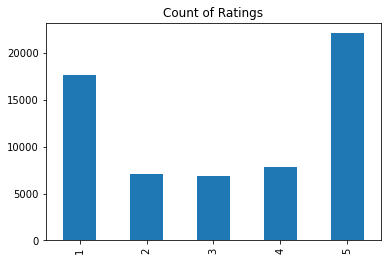

In [7]:
ax = data['Rating'].value_counts().sort_index().plot(kind='bar',title='Count of Ratings')

We see that there was a huge spike of negative reviews on a specific few days in March, as well as in mid-April. What seems to be the problem?

In [8]:
lowest = df1.sort_values('Rating').iloc[:10,] # We can pick and choose the dates with the 10 lowest ratings from here
lowestmarapr = lowest.sort_index().loc['2022-3':'2022-4'].index # we want the dates in March and April specifically.
badreviews = data.loc[(data.index.floor("d").isin(lowestmarapr)) & (data['Rating']<3)]

rawbr = ''.join(badreviews['Review'].array) # Join all reviews into a single string.

def totokens(s): # Tokenization function: we separate into sentences, then separate the sentences into word tokens.
    sentences = nltk.sent_tokenize(s)
    sentences = [nltk.word_tokenize(sent) for sent in sentences]
    return sentences

stop = stopwords.words('english') # Prepare the stopwords
stop.remove('in') # Omit "in" because the phrase "log in" is important to our analysis.

badreviews = totokens(rawbr)
badreviews = [i.lower() for j in badreviews for i in j]
badreviews = [i for i in badreviews if i not in stop and i.isalpha()]

Now we plot the frequency distributions for the words:

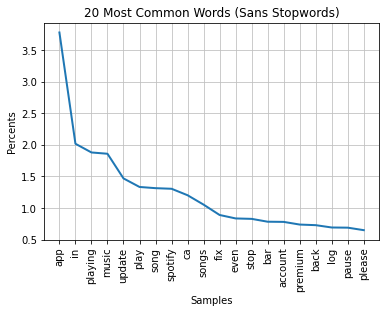

<AxesSubplot:title={'center':'20 Most Common Words (Sans Stopwords)'}, xlabel='Samples', ylabel='Percents'>

In [9]:
f1 = nltk.FreqDist(badreviews)
f1.plot(20, title='20 Most Common Words (Sans Stopwords)', percents=True)

Note that 'ca' is considered a word. This is because tokenization splits words such as "can't" into "ca" and "n't", and we removed words with punctuation from consideration. 

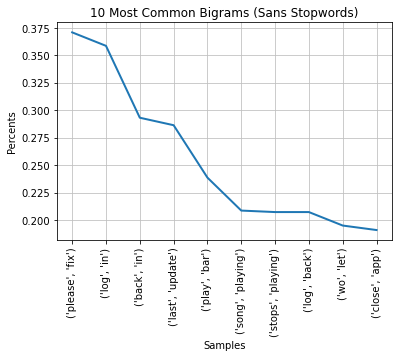

<AxesSubplot:title={'center':'10 Most Common Bigrams (Sans Stopwords)'}, xlabel='Samples', ylabel='Percents'>

In [10]:
bi_br = [i for i in list(nltk.bigrams(badreviews))]
f2 = nltk.FreqDist(bi_br)
f2.plot(10, title='10 Most Common Bigrams (Sans Stopwords)', percents=True)

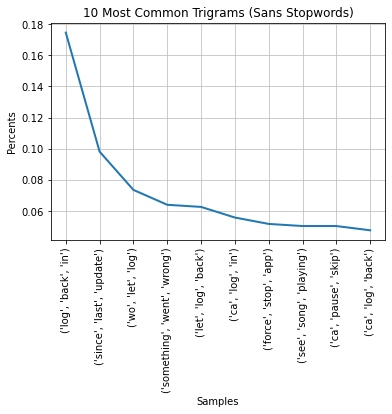

<AxesSubplot:title={'center':'10 Most Common Trigrams (Sans Stopwords)'}, xlabel='Samples', ylabel='Percents'>

In [11]:
tri_br = [i for i in list(nltk.trigrams(badreviews))]
f3 = nltk.FreqDist(tri_br)
f3.plot(10, title='10 Most Common Trigrams (Sans Stopwords)', percents=True)

In [12]:
def result(n): return [i[0] if type(i[0])==str else ' '.join(i[0]) for i in n]
                         
print(f'Most common words (without stopwords): {result(f1.most_common(20))}\n\
      Bigrams:\n {result(f2.most_common(20))} \n\
      Trigrams:\n {result(f3.most_common(20))}')

Most common words (without stopwords): ['app', 'in', 'playing', 'music', 'update', 'play', 'song', 'spotify', 'ca', 'songs', 'fix', 'even', 'stop', 'bar', 'account', 'premium', 'back', 'log', 'pause', 'please']
      Bigrams:
 ['please fix', 'log in', 'back in', 'last update', 'play bar', 'song playing', 'stops playing', 'log back', 'wo let', 'close app', 'stop playing', 'in app', 'latest update', 'recent update', 'playing music', 'pause skip', 'ca even', 'ca pause', 'playing bar', 'ca log'] 
      Trigrams:
 ['log back in', 'since last update', 'wo let log', 'something went wrong', 'let log back', 'ca log in', 'force stop app', 'see song playing', 'ca pause skip', 'ca log back', 'force close app', 'randomly stops playing', 'let log in', 'play bar disappears', 'ca see song', 'log in account', 'music stops playing', 'bar keeps disappearing', 'sign back in', 'logged ca log']


Let's further analyse the contexts using the common words we've found. Collocations shows us bigrams that appear more frequently than they should 

In [13]:
badreviewtxt = nltk.Text(nltk.word_tokenize(rawbr))
badreviewtxt.collocations()

Please fix; last update; n't show; n't let; log back; play bar; recent
update; n't even; latest update; stops playing; currently playing;
went wrong; n't work; even though; please fix; multiple times; stop
playing; new update; force close; bar disappears


We can review the context under which each word appears, and harvest information on the problems from there.

In [14]:
badreviewtxt.concordance(['last','update'])

Displaying 25 of 207 matches:
e , skip , or play back songs.The last update is miserable . Randomly plays and
eat 90 % of the time but man this last update is pitiful . Review will go back 
verything you guys broke with the last update . No longer can I see favorite so
ng cuts out every 10-15 seconds . Last update ruined everything . Fix it or I '
ned to absolute garbage since the last update . The status bar disappears , mus
 with the service , but since the last update , whenever I have my earphones in
shes.Shittiest app ever after the last update . Consistently shuts down randoml
hin the Spotify app itself . This last update was n't tested at all . I will ha
E FOR USE WHILE DRIVING SINCE THE LAST UPDATE , I WILL NOT BUY YOUR $ 90 JUNK D
or podcasts.Hot garbage since the last update . Support does n't care and there
pisode is.Loved the app till this last update . The app barely works now : my m
 can do so much betterbuggy since last update . constant stops of playing and p
.. Saw thi

In [15]:
badreviewtxt.concordance(["n't",'show'])

Displaying 25 of 186 matches:
two and then randomly stop . It wo n't show me what track is playing and I ca 
the last couple weeks . Spotify wo n't show up in the drop down , so i have to
metimes it 'd stop playing , would n't show what song was playing at the momen
app at least twice because it does n't show me the current song playing so reg
 it when I click on a song it does n't show that 's the one that 's playing ? 
get a refund or what ? LolApp does n't show playing now , need to restart it b
 the controller at the bottom does n't show up . Forces me to close the app an
up , stops playing at times . Does n't show that it 's playing music but audio
es it stops playing . It also does n't show what 's playing . I might just swi
d to be good . Now the controls do n't show 90 % of the time so you ca n't cha
top , sing playing and controls wo n't show up on home screen . When I open th
w.Since update , song playing does n't show on drop down menu , and pressing p
o n't connect to car p

Some things are immediately evident: the app updates on these days were a buggy mess. By excluding these days from analysis, we should be able to get an idea of the more general areas for improvement.

We repeat the process for tokenization and analysis on the rest of the dataset, excluding the days we previously analysed.

In [16]:
dfgood = data.loc[~data.index.floor('d').isin(lowestmarapr)]
rawgr = ''.join(dfgood.Review.array)
goodreviews = totokens(rawgr)
goodreviews = [i.lower() for j in goodreviews for i in j]
goodreviews = [i for i in goodreviews if i not in stop and i.isalpha()]

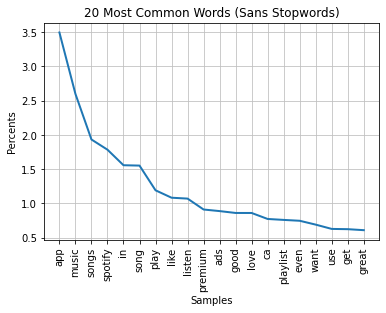

<AxesSubplot:title={'center':'20 Most Common Words (Sans Stopwords)'}, xlabel='Samples', ylabel='Percents'>

In [17]:
f4 = nltk.FreqDist(goodreviews)
f4.plot(20, title='20 Most Common Words (Sans Stopwords)', percents=True)

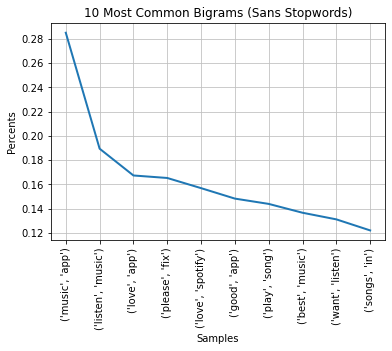

<AxesSubplot:title={'center':'10 Most Common Bigrams (Sans Stopwords)'}, xlabel='Samples', ylabel='Percents'>

In [18]:
bi_gr = [i for i in list(nltk.bigrams(goodreviews))]
f5 = nltk.FreqDist(bi_gr)
f5.plot(10, title='10 Most Common Bigrams (Sans Stopwords)', percents=True)

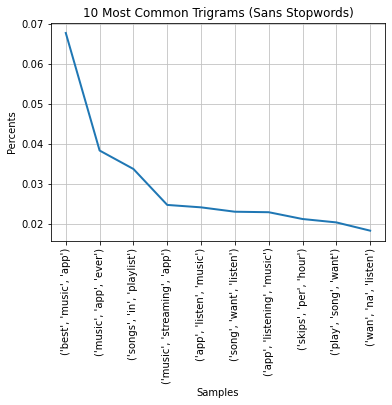

<AxesSubplot:title={'center':'10 Most Common Trigrams (Sans Stopwords)'}, xlabel='Samples', ylabel='Percents'>

In [19]:
tri_gr = [i for i in list(nltk.trigrams(goodreviews))] # Trigrams including stopwords for context
f6 = nltk.FreqDist(tri_gr)
f6.plot(10, title='10 Most Common Trigrams (Sans Stopwords)', percents=True)

In [20]:
print(f'Most common words (without stopwords): {result(f4.most_common(20))}\n\
      Bigrams:\n {result(f5.most_common(20))} \n\
      Trigrams:\n {result(f6.most_common(20))}')

Most common words (without stopwords): ['app', 'music', 'songs', 'spotify', 'in', 'song', 'play', 'like', 'listen', 'premium', 'ads', 'good', 'love', 'ca', 'playlist', 'even', 'want', 'use', 'get', 'great']
      Bigrams:
 ['music app', 'listen music', 'love app', 'please fix', 'love spotify', 'good app', 'play song', 'best music', 'want listen', 'songs in', 'great app', 'song want', 'play music', 'ca even', 'in playlist', 'play songs', 'listening music', 'app music', 'many ads', 'app ever'] 
      Trigrams:
 ['best music app', 'music app ever', 'songs in playlist', 'music streaming app', 'app listen music', 'song want listen', 'app listening music', 'skips per hour', 'play song want', 'wan na listen', 'best music streaming', 'songs want listen', 'ads in row', 'song in playlist', 'really good app', 'app easy use', 'ca even listen', 'song want play', 'ca even play', 'using spotify years']


We definitely see a lot more positivity (trigrams like "best music app" and "best music streaming" appear), but some problems still resurface: reviews complain about not being able to listen or play music, and "please fix" is the 4th most common bigram.

In [21]:
goodreviewstxt = nltk.Text(nltk.word_tokenize(rawgr))
goodreviewstxt.collocations()

n't even; Please fix; internet connection; Joe Rogan; best music; many
ads; please fix; n't play; new update; liked songs; even though; music
app; n't know; n't work; free version; sound quality; n't let; love
Spotify; good app; every time


Let's explore the contexts surrounding some of the common bigrams.

In [22]:
goodreviewstxt.concordance(['internet','connection'])

Displaying 25 of 574 matches:
installed app * i have strong internet connection * cleared cache WHAT ELSE do 
 n't play any song It says no internet connection even when I am connected to i
and its saying i dont have an internet connection 🙃when you search for a specif
artist as I am stuck with 'No internet connection available ' on a high speed W
dd panugaContinuing to say no internet connection .. with full bars . All other
en more wrong . DrI have good internet connection , but system keep saying that
missing . Randomly says `` no internet connection '' while clearly connected to
ong to play as there is no `` internet connection '' I am not able to listen to
 in the app always showing no internet connection . My other apps are doing fin
 over mobile data and says no internet connection seriously ....... Furthermore
ike something went wrong , no internet connection etc and all Please if this co
ng plays . It keeps saying no internet connection try again . I have followed a
e way it s

In [23]:
goodreviewstxt.concordance(['sound','quality'])

Displaying 25 of 361 matches:
at song next month maybe not.The sound quality is really good and I can listen 
puts songs on my playlists . The sound quality is really good but you have to f
 play listI just wish for better sound quality and a light mode optionI pay for
 music is great and it has great sound quality but i had 11 ads in a row . I us
 pause and so on.Easy to use but sound quality is so so100 % has everything ! T
d I 'm a premium user I love the sound quality and the music they put on here t
rent from the web version , good sound quality yet any playlist song Is complet
 premium ... Fix this pleaseGood sound quality ❤️❤️App works great ! ! ! ! Grea
ify is really great . I love the sound quality and the way it creates playlists
I to find anything is terrible , sound quality is average and when you download
close it from the background.The sound quality and other features are exception
d add more songs and improve the sound quality just like AM ( it 's already goo
 , instead

As expected, reviewers had a mainly negative sentiment on "internet connection", but a generally positive sentiment on "sound quality". What about reviews that feature "Joe Rogan"?

In [24]:
dfgood[dfgood.Review.str.contains('Joe Rogan')].Rating.mean()

2.9667519181585678

In [25]:
dfgood.Rating.mean()

3.2544879327488023

In [26]:
goodreviewstxt.concordance(['Joe','Rogan'])

Displaying 25 of 444 matches:
 anywhere else . If it was n't for Joe Rogan and the Dark Horse podcast , I 'd 
y reason i have spotify is for the joe rogan experience and its almost not wort
pp.Trash app would n't even use if Joe Rogan had n't moved over . Literally ran
our app needs a MAJOR redesign.The Joe Rogan podcast deal did n't make podcasts
video when attached to Bluetooth , joe Rogan is carrying this entire platformMy
ing in the appropriate episodes of Joe Rogan Podcast . ( ͝° ͜ʖ͡° ) ᕤUser friend
 ANGRY😡🙄Best music app out there ! Joe Rogan for life ! ! Was logged out out of
TION ! ? Huh ? ? If it was n't for Joe Rogan , I 'd have bailed on this app a l
o use for music . Do n't listen to Joe Rogan . I use Spotify everyday I love it
ows me ! Love it ! ! ! Honestly if Joe Rogan was n't on here i would have you t
account again.Music is awesome ! ! Joe Rogan podcast is the only reason I downl
 . I install this to listen to the Joe Rogan Experience podcast and Glitched li
is app mai

We see that mentions of Joe Rogan are correlated with a small decrease in average score. Googling reveals that Joe Rogan's podcasts are controversial, making Spotify's decision to pay him to host his podcasts a controversial one. This could have contributed to the score decrease.

## Summary
- NLTK was used to explore reviews and analyse pain points of reviewers
- Whenever an update breaks something, we can expect a large number of negative reviewers.
- Complaints on logging in remain one of the top problems among reviewers.